In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from pmdarima.arima import auto_arima
from arch import arch_model
import matplotlib.pyplot as plt

# read fed funds rate data from FEDFUNDS.csv
fed_funds = pd.read_csv('FEDFUNDS.csv', index_col='DATE', parse_dates=True)
fed_funds = fed_funds.loc['2000-01-01':]

# how many days to forecast
test_size = 30

forecasts = []
actuals = []

# ARIMA GARCH
for i in range(test_size, 0, -1):
    train = fed_funds.iloc[:-i]

    change = train.pct_change().dropna()
    change *= 100 # resize for garch model

    # fit arima model
    arima_model = auto_arima(change, seasonal=False, trace=False, suppress_warnings=True)
    arima_residuals = arima_model.resid()

    # fit garch model
    garch = arch_model(arima_residuals, vol='Garch', p=1, q=1)
    garch_fit = garch.fit(disp='off')

    predicted_mu = arima_model.predict(n_periods=1).item()
    garch_forecast = garch_fit.forecast(horizon=1)
    predicted_et = garch_forecast.mean['h.1'].iloc[-1]
    prediction = predicted_mu + predicted_et

    predicted_fed_funds = train.iloc[-1].item()*(1 + prediction/100)
    actual_fed_funds = fed_funds.iloc[-i].item()

    date = str(fed_funds.iloc[-i].name).split(' ')[0]
    print(f'[{date}] Predicted: {predicted_fed_funds}, Actual: {actual_fed_funds}')

    forecasts.append(predicted_fed_funds)
    actuals.append(actual_fed_funds)

[2021-09-01] Predicted: 0.08226826032590909, Actual: 0.08
[2021-10-01] Predicted: 0.08034542387517257, Actual: 0.08
[2021-11-01] Predicted: 0.07786080949892207, Actual: 0.08
[2021-12-01] Predicted: 0.08147961103290406, Actual: 0.08
[2022-01-01] Predicted: 0.07727481764810434, Actual: 0.08
[2022-02-01] Predicted: 0.08172068953547963, Actual: 0.08
[2022-03-01] Predicted: 0.07723223689027123, Actual: 0.2
[2022-04-01] Predicted: 0.32224815787604655, Actual: 0.33
[2022-05-01] Predicted: 0.332671331019466, Actual: 0.77
[2022-06-01] Predicted: 1.2224606615552271, Actual: 1.21
[2022-07-01] Predicted: 1.7343690625259274, Actual: 1.68
[2022-08-01] Predicted: 2.168453029835415, Actual: 2.33
[2022-09-01] Predicted: 3.1617214811351384, Actual: 2.56
[2022-10-01] Predicted: 2.841668901955405, Actual: 3.08
[2022-11-01] Predicted: 3.6878508309357985, Actual: 3.78
[2022-12-01] Predicted: 4.602187752126782, Actual: 4.1
[2023-01-01] Predicted: 4.578590290231583, Actual: 4.33
[2023-02-01] Predicted: 4.7446

In [2]:
# find mse of ARIMA-GARCH data
mse = np.mean((np.array(forecasts) - np.array(actuals))**2)
print(f'MSE: {mse}')


MSE: 0.06015420535803993


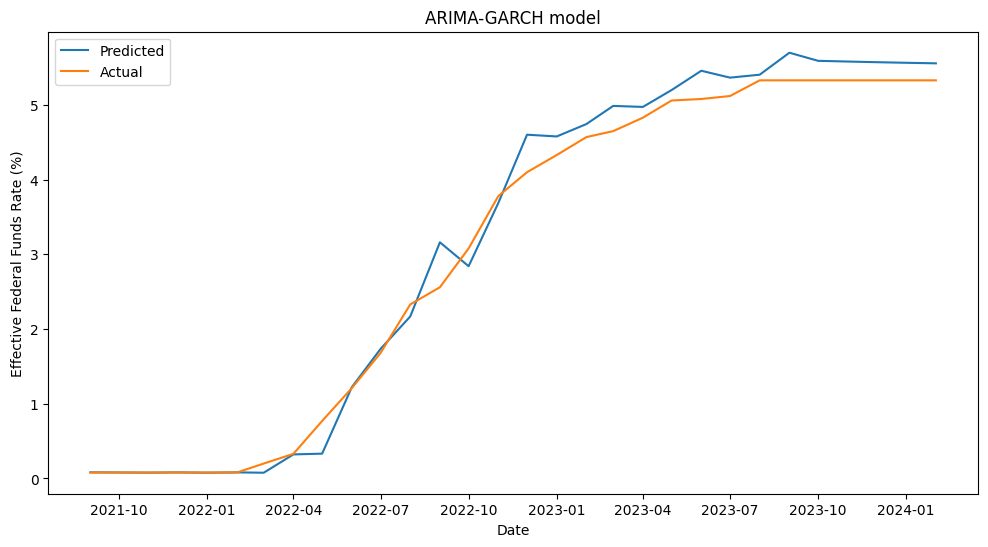

In [3]:
plt.figure(figsize=(12, 6))  # Increase the figure size to 12 inches by 6 inches
plt.plot(fed_funds.index[-test_size:], forecasts, label='Predicted')
plt.plot(fed_funds.index[-test_size:], actuals, label='Actual')
plt.xlabel('Date')
plt.ylabel('Effective Federal Funds Rate (%)')
plt.title('ARIMA-GARCH model')
plt.legend()
plt.show()


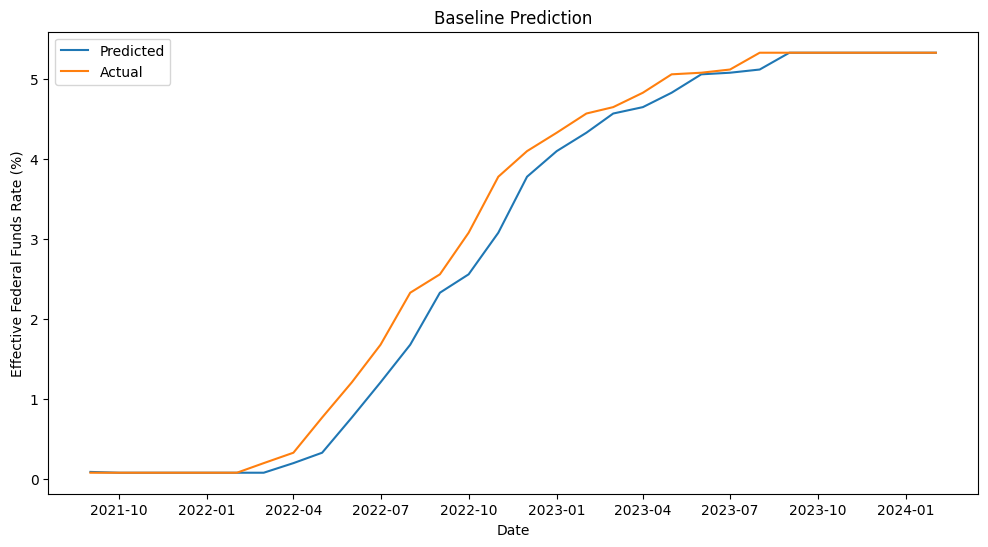

In [4]:
# now, predict solely based off of yesterday's rate as a bad baseline
forecasts = actuals.copy()
forecasts.insert(0, fed_funds.iloc[-test_size-1].item())
forecasts.pop()
plt.figure(figsize=(12, 6))  # Increase the figure size to 12 inches by 6 inches
plt.plot(fed_funds.index[-test_size:], forecasts, label='Predicted')
plt.plot(fed_funds.index[-test_size:], actuals, label='Actual')
plt.xlabel('Date')
plt.ylabel('Effective Federal Funds Rate (%)')
plt.title('Baseline Prediction')
plt.legend()
plt.show()

In [5]:
# find mse of baseline data
mse = np.mean((np.array(forecasts) - np.array(actuals))**2)
print(f'MSE: {mse}')

MSE: 0.0742


In [6]:
# now, predict solely based off of ARIMA model

forecasts = []
actuals = []

for i in range(test_size, 0, -1):
    train = fed_funds.iloc[:-i]

    change = train.pct_change().dropna()
    change *= 100 # resize for garch model

    # fit arima model
    arima_model = auto_arima(change, seasonal=False, trace=False, suppress_warnings=True)
    arima_residuals = arima_model.resid()

    predicted_mu = arima_model.predict(n_periods=1).item()

    predicted_fed_funds = train.iloc[-1].item()*(1 + prediction/100)
    actual_fed_funds = fed_funds.iloc[-i].item()

    date = str(fed_funds.iloc[-i].name).split(' ')[0]
    print(f'[{date}] Predicted: {predicted_fed_funds}, Actual: {actual_fed_funds}')

    forecasts.append(predicted_fed_funds)
    actuals.append(actual_fed_funds)

[2021-09-01] Predicted: 0.09384057946394651, Actual: 0.08
[2021-10-01] Predicted: 0.08341384841239691, Actual: 0.08
[2021-11-01] Predicted: 0.08341384841239691, Actual: 0.08
[2021-12-01] Predicted: 0.08341384841239691, Actual: 0.08
[2022-01-01] Predicted: 0.08341384841239691, Actual: 0.08
[2022-02-01] Predicted: 0.08341384841239691, Actual: 0.08


MSE: 0.060659440494026204


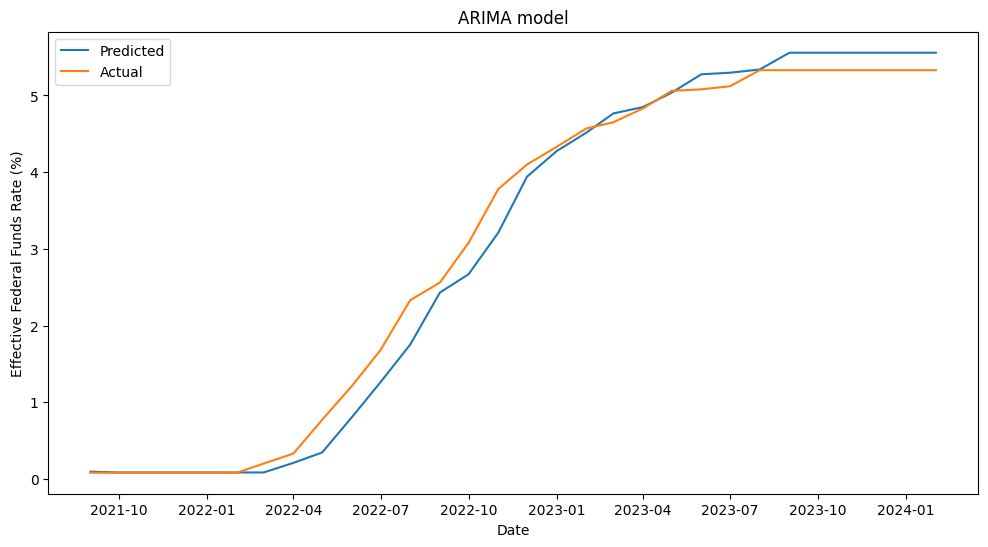

In [ ]:
# find mse of ARIMA data
mse = np.mean((np.array(forecasts) - np.array(actuals))**2)
print(f'MSE: {mse}')

plt.figure(figsize=(12, 6))  # Increase the figure size to 12 inches by 6 inches
plt.plot(fed_funds.index[-test_size:], forecasts, label='Predicted')
plt.plot(fed_funds.index[-test_size:], actuals, label='Actual')
plt.xlabel('Date')
plt.ylabel('Effective Federal Funds Rate (%)')
plt.title('ARIMA model')
plt.legend()
plt.show()